In [1]:
!pip install tensorflow-federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

# **Dataset**

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/CICIoV2024/binary.csv')
data


,ID0,ID1,ID2,ID3,ID4,ID5,ID6,ID7,ID8,ID9,...,DATA_710,DATA_711,DATA_712,DATA_713,DATA_714,DATA_715,DATA_716,label,category,specific_class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,BENIGN,BENIGN,BENIGN
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,BENIGN,BENIGN,BENIGN
2,0,0,0,0,0,0,0,1,0,0,...,1,1,1,1,1,1,1,BENIGN,BENIGN,BENIGN
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,BENIGN,BENIGN,BENIGN
4,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,BENIGN,BENIGN,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408214,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,ATTACK,SPOOFING,STEERING_WHEEL
1408215,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,ATTACK,SPOOFING,STEERING_WHEEL
1408216,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,ATTACK,SPOOFING,STEERING_WHEEL
1408217,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,ATTACK,SPOOFING,STEERING_WHEEL


# **Binary Classification using "label"**

**7 clients, 1D conv, Adam, lr=0.001**

In [1]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [2]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/binary.csv")


In [3]:
# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create train data for clients with a smaller batch size
def create_tf_dataset_for_client(client_data, batch_size=16):
    data = client_data.iloc[:, :-3].values.astype(np.float32)  # Exclude the last three columns (label, category, specific_class)
    labels = client_data['label'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(batch_size)

# Use only a subset of the training data for each client
client_data_splits = [client_data.sample(frac=0.5, random_state=42) for client_data in np.array_split(train_df, 7)]

# Create TF datasets for each client with reduced batch size
train_data = [create_tf_dataset_for_client(client_data, batch_size=16) for client_data in client_data_splits]

# Use only a subset of the test data
test_df_subset = test_df.sample(frac=0.5, random_state=42)
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df_subset.iloc[:, :-3].values.astype(np.float32), test_df_subset['label'].values.astype(np.int32))
).batch(16)


In [4]:
df_shape = df.shape[1]

In [5]:
del df

Training and Testing Results
Round 1, Training accuracy: 0.9992, Training loss: 0.0023, Num examples: 563290, Num batches: 35210
Round 1, Testing accuracy: 1.0000, Testing loss: 0.0002, Num examples: 140822, Num batches: 8802
8802/8802 [==============================] - 23s 3ms/step
Round 1, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000

Round 2, Training accuracy: 0.9999, Training loss: 0.0006, Num examples: 563290, Num batches: 35210
Round 2, Testing accuracy: 1.0000, Testing loss: 0.0000, Num examples: 140822, Num batches: 8802
8802/8802 [==============================] - 22s 2ms/step
Round 2, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000

Round 3, Training accuracy: 0.9999, Training loss: 0.0004, Num examples: 563290, Num batches: 35210
Round 3, Testing accuracy: 1.0000, Testing loss: 0.0000, Num examples: 140822, Num batches: 8802
8802/8802 [==============================] - 23s 3ms/step
Round 3, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000

Round 4, Training ac

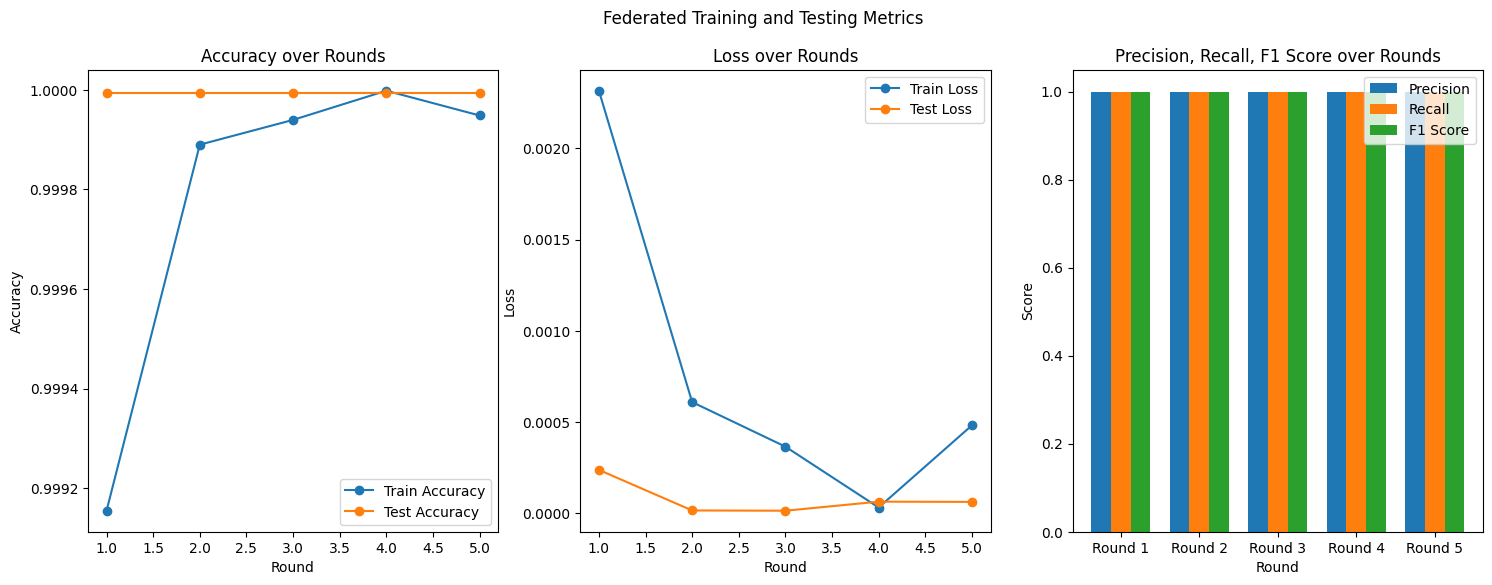

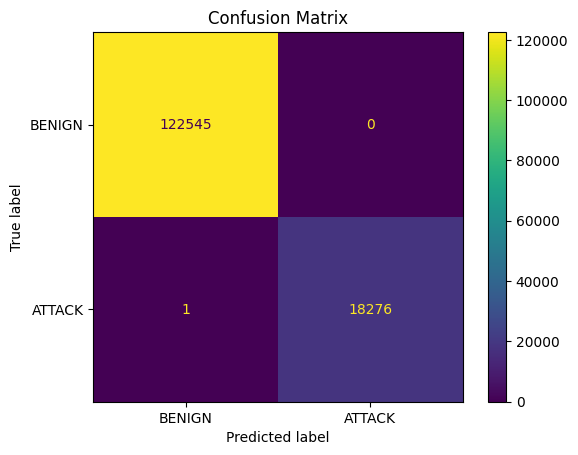

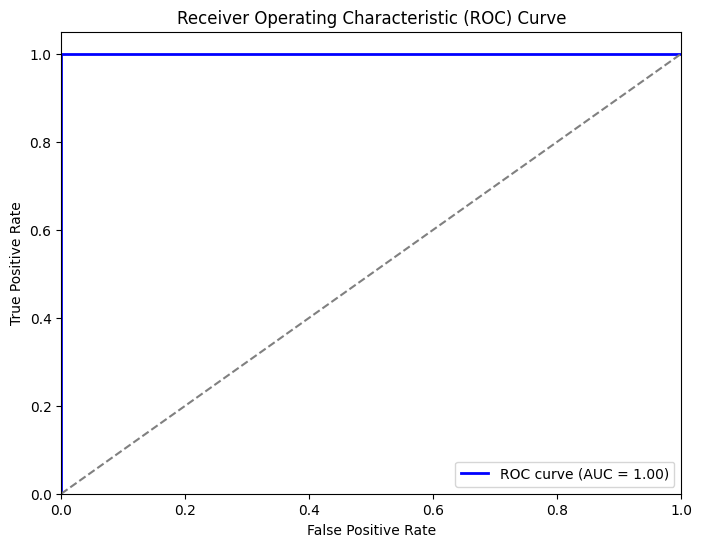

In [6]:
# Define the Keras model
def build_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((df_shape - 3, 1), input_shape=(df_shape - 3,)),  # Adjust input shape based on new data
        tf.keras.layers.Conv1D(32, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(label_mapping), activation='softmax')
    ])
    return model

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = build_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )


# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
)

state = trainer.initialize()

evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn)
evaluation_state = evaluation_process.initialize()

# Lists to store training and testing metrics
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []
precisions = []
recalls = []
f1_scores = []

print("Training and Testing Results")

for round_num in range(5):
    # Training
    state, metrics = trainer.next(state, train_data)
    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

    # Testing
    model_weights = trainer.get_model_weights(state)
    evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)
    evaluation_output = evaluation_process.next(evaluation_state, [test_data])
    test_metrics = evaluation_output.metrics
    test_accuracy = test_metrics['client_work']['eval']['current_round_metrics']['sparse_categorical_accuracy']
    test_loss = test_metrics['client_work']['eval']['current_round_metrics']['loss']
    num_examples = test_metrics['client_work']['eval']['current_round_metrics']['num_examples']
    num_batches = test_metrics['client_work']['eval']['current_round_metrics']['num_batches']
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    print(f"Round {round_num+1}, Testing accuracy: {test_accuracy:.4f}, Testing loss: {test_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}")

    # Evaluate precision, recall, and F1 score for the current round
    keras_model = build_keras_model()
    keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    keras_model.set_weights(model_weights.trainable)

    y_true = np.concatenate([y for x, y in test_data], axis=0)
    y_pred = np.argmax(keras_model.predict(test_data), axis=1)
    y_pred_probs = keras_model.predict(test_data)[:, 1]  # Assuming positive class is index 1

    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    print(f'Round {round_num+1}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print()

# Plot accuracy and loss over rounds
rounds = range(1, 6)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(rounds, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(rounds, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(rounds, train_losses, marker='o', label='Train Loss')
plt.plot(rounds, test_losses, marker='o', label='Test Loss')
plt.title('Loss over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
bar_width = 0.25
bar_positions = np.arange(len(rounds))

plt.bar(bar_positions - bar_width, precisions, width=bar_width, label='Precision')
plt.bar(bar_positions, recalls, width=bar_width, label='Recall')
plt.bar(bar_positions + bar_width, f1_scores, width=bar_width, label='F1 Score')
plt.title('Precision, Recall, F1 Score over Rounds')
plt.xlabel('Round')
plt.ylabel('Score')
plt.xticks(bar_positions, [f'Round {i}' for i in rounds])
plt.legend()

plt.suptitle('Federated Training and Testing Metrics')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# ROC curve and AUC after all rounds of training
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Training and Testing Results
Round 1, Training accuracy: 0.9927, Training loss: 0.0281, Num examples: 1126575, Num batches: 35206
Round 1, Testing accuracy: 0.9826, Testing loss: 0.0365, Num examples: 281644, Num batches: 8802
8802/8802 [==============================] - 19s 2ms/step
Round 1, Precision: 0.9415, Recall: 0.9900, F1 Score: 0.9639

Round 2, Training accuracy: 0.9959, Training loss: 0.0125, Num examples: 1126575, Num batches: 35206
Round 2, Testing accuracy: 0.9964, Testing loss: 0.0129, Num examples: 281644, Num batches: 8802
8802/8802 [==============================] - 15s 2ms/step
Round 2, Precision: 0.9980, Recall: 0.9864, F1 Score: 0.9921

Round 3, Training accuracy: 0.9934, Training loss: 0.0579, Num examples: 1126575, Num batches: 35206
Round 3, Testing accuracy: 0.9752, Testing loss: 0.3426, Num examples: 281644, Num batches: 8802
8802/8802 [==============================] - 15s 2ms/step
Round 3, Precision: 0.9861, Recall: 0.9052, F1 Score: 0.9406

Round 4, Training

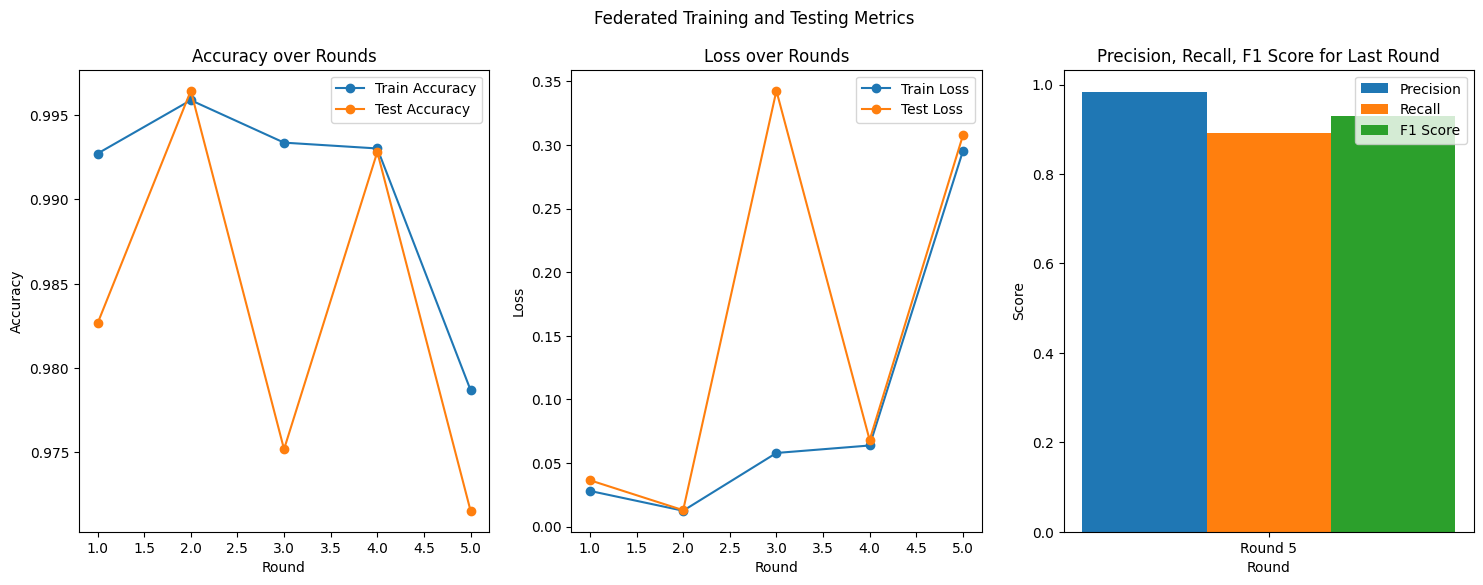

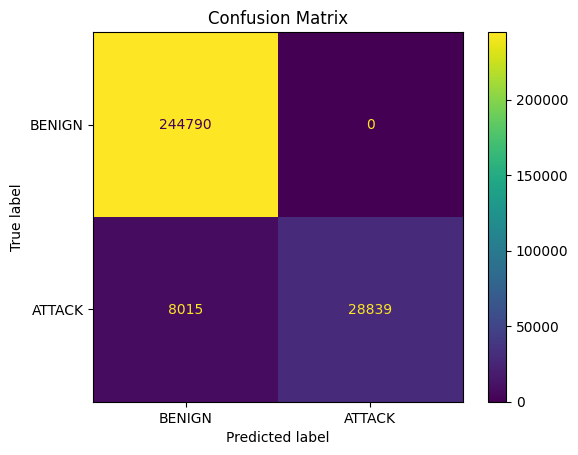

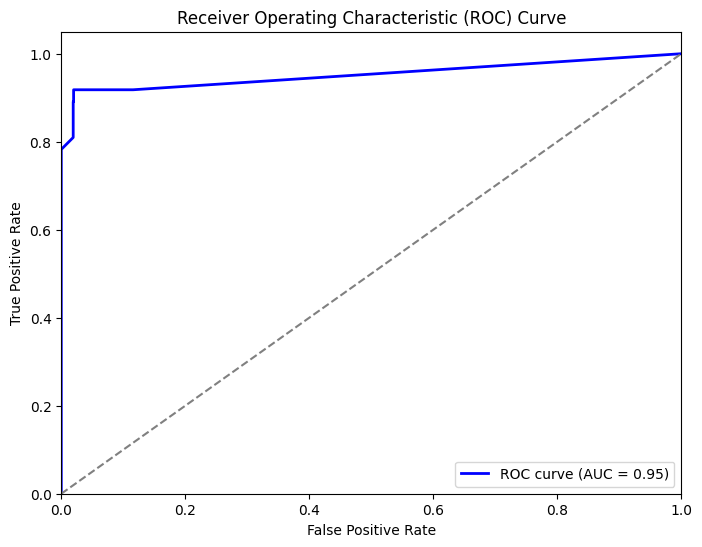

In [7]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/decimal.csv")

# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## Create train data for two clients
def create_tf_dataset_for_client(client_data):
    data = client_data.iloc[:, 1:9].values.astype(np.float32)
    labels = client_data['label'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(32)

# Split the train_df into two parts for two clients
client_0_data, client_1_data = train_test_split(train_df, test_size=0.5, random_state=42)

# Create TF datasets for each client
train_data = [
    create_tf_dataset_for_client(client_0_data),
    create_tf_dataset_for_client(client_1_data)
]

# Create a TF dataset for the test data
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df.iloc[:, 1:9].values.astype(np.float32), test_df['label'].values.astype(np.int32))
).batch(32)

# Define the Keras model
def build_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((8, 1), input_shape=(8,)),
        tf.keras.layers.Conv1D(32, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(np.max(df['label']) + 1, activation='softmax')
    ])
    return model

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = build_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
)

state = trainer.initialize()

evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn)
evaluation_state = evaluation_process.initialize()

# Lists to store training and testing metrics
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []
precisions = []
recalls = []
f1_scores = []

print("Training and Testing Results")

for round_num in range(5):
    # Training
    state, metrics = trainer.next(state, train_data)
    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

    # Testing
    model_weights = trainer.get_model_weights(state)
    evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)
    evaluation_output = evaluation_process.next(evaluation_state, [test_data])
    test_metrics = evaluation_output.metrics
    test_accuracy = test_metrics['client_work']['eval']['current_round_metrics']['sparse_categorical_accuracy']
    test_loss = test_metrics['client_work']['eval']['current_round_metrics']['loss']
    num_examples = test_metrics['client_work']['eval']['current_round_metrics']['num_examples']
    num_batches = test_metrics['client_work']['eval']['current_round_metrics']['num_batches']
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    print(f"Round {round_num+1}, Testing accuracy: {test_accuracy:.4f}, Testing loss: {test_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}")

    # Evaluate precision, recall, and F1 score for the current round
    keras_model = build_keras_model()
    keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    keras_model.set_weights(model_weights.trainable)

    y_true = np.concatenate([y for x, y in test_data], axis=0)
    y_pred = np.argmax(keras_model.predict(test_data), axis=1)
    y_pred_probs = keras_model.predict(test_data)[:, 1]  # Assuming positive class is index 1

    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    print(f'Round {round_num+1}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print()

# Print the final round accuracy, precision, recall, and F1 score
print("Final Round Accuracy: {:.4f}".format(test_accuracies[-1]))
print("Final Precision: {:.4f}".format(precisions[-1]))
print("Final Recall: {:.4f}".format(recalls[-1]))
print("Final F1 Score: {:.4f}".format(f1_scores[-1]))

# Plot accuracy and loss over rounds
rounds = range(1, 6)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(rounds, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(rounds, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(rounds, train_losses, marker='o', label='Train Loss')
plt.plot(rounds, test_losses, marker='o', label='Test Loss')
plt.title('Loss over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

# Plot Precision, Recall, and F1 Score for the last round
plt.subplot(1, 3, 3)
bar_width = 0.25
bar_positions = np.arange(1)

plt.bar(bar_positions - bar_width, precisions[-1:], width=bar_width, label='Precision')
plt.bar(bar_positions, recalls[-1:], width=bar_width, label='Recall')
plt.bar(bar_positions + bar_width, f1_scores[-1:], width=bar_width, label='F1 Score')
plt.title('Precision, Recall, F1 Score for Last Round')
plt.xlabel('Round')
plt.ylabel('Score')
plt.xticks(bar_positions, ['Round 5'])
plt.legend()

plt.suptitle('Federated Training and Testing Metrics')
plt.show()

# Confusion Matrix for the last round
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# ROC curve and AUC after all rounds of training
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()